In [1]:
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_max_intensity_for_dataset, load_and_prepare_images, create_cross_val_splits
from utils.model_utils import train_and_eval
from torch import nn
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
EPOCHS = 100
# image_path = "D:/AIF_DCE"
image_path = "D:/iCAT_IMAGES/"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\svenalrik\anaconda3\envs\dev-env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)  # Patient 102(1) contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)  # Patient 112(11) lacks a single pixel array
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars = ['Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])
vol_intensities = get_max_intensity_for_dataset(image_data)
train_val_images, test_images, train_val_labels, test_labels = load_and_prepare_images(image_data, mca_labels, vol_intensities, SEED, extra_vols = 5)
train_images, val_images, train_labels, val_labels = load_and_prepare_images(train_val_images, train_val_labels, vol_intensities, SEED, extra_vols=5)

Added data 1090. Original amount of data 3264
Size training data: 3903. Size test_data: 451.
True labels in training: 1170 of 3903 (30.0%).
True labels in test: 138 of 451 (30.599999999999998%)
Added data 975. Original amount of data 2928
Size training data: 3462. Size test_data: 441.
True labels in training: 1044 of 3462 (30.2%).
True labels in test: 126 of 441 (28.599999999999998%)


### Model Selection
Using train and validation data

In [3]:
from utils.datahandling_utils import SliceIntensityDataset
from torch.utils.data import DataLoader

train_dataset = SliceIntensityDataset(train_images, train_labels, normalize=True, crop=0.7)
val_dataset = SliceIntensityDataset(val_images, val_labels, normalize=True, crop=0.7)
test_dataset = SliceIntensityDataset(test_images, test_labels, normalize=True, crop=0.7)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
from ray import air, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from models.dense_net_torch import DenseNet
from utils.model_utils import train, validate

def model_select(config):
    torch.manual_seed(SEED)
    model = DenseNet(growth_rate=config['growth_rate'], num_init_features = config['init_features'], bn_size = config['bn_size'], drop_rate=config['drop_rate'], num_classes=1)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], amsgrad=True)
    criterion = nn.BCEWithLogitsLoss().to(device)
    for epoch in range(100):
        train(train_loader, model, criterion, optimizer, device)
        loss = validate(val_loader, model, criterion, device, apr=True)

        tune.report(val_loss = loss[0].item(), accuracy = loss[1], precision = loss[2], recall = loss[3])

search_space = {
    'growth_rate': tune.randint(12,20),
    'init_features' : tune.randint(18, 25),
    'bn_size' : tune.randint(3, 8),
    'drop_rate' : tune.uniform(0.,0.3),
    'lr' : tune.loguniform(1e-5, 1e-3),
    'weight_decay' : tune.uniform(0., 0.1),
}

asha_scheduler = ASHAScheduler(metric="val_loss", mode="min", grace_period=20)

hyperopt_search = HyperOptSearch(metric="val_loss", mode="min")


tuner = tune.Tuner(
    model_select,
    tune_config=tune.TuneConfig(
    num_samples=100,
    max_concurrent_trials=2,
    scheduler=asha_scheduler,
    search_alg=hyperopt_search,
    ),
    param_space=search_space
)

results = tuner.fit()

AttributeError: 'NoneType' object has no attribute 'plot'

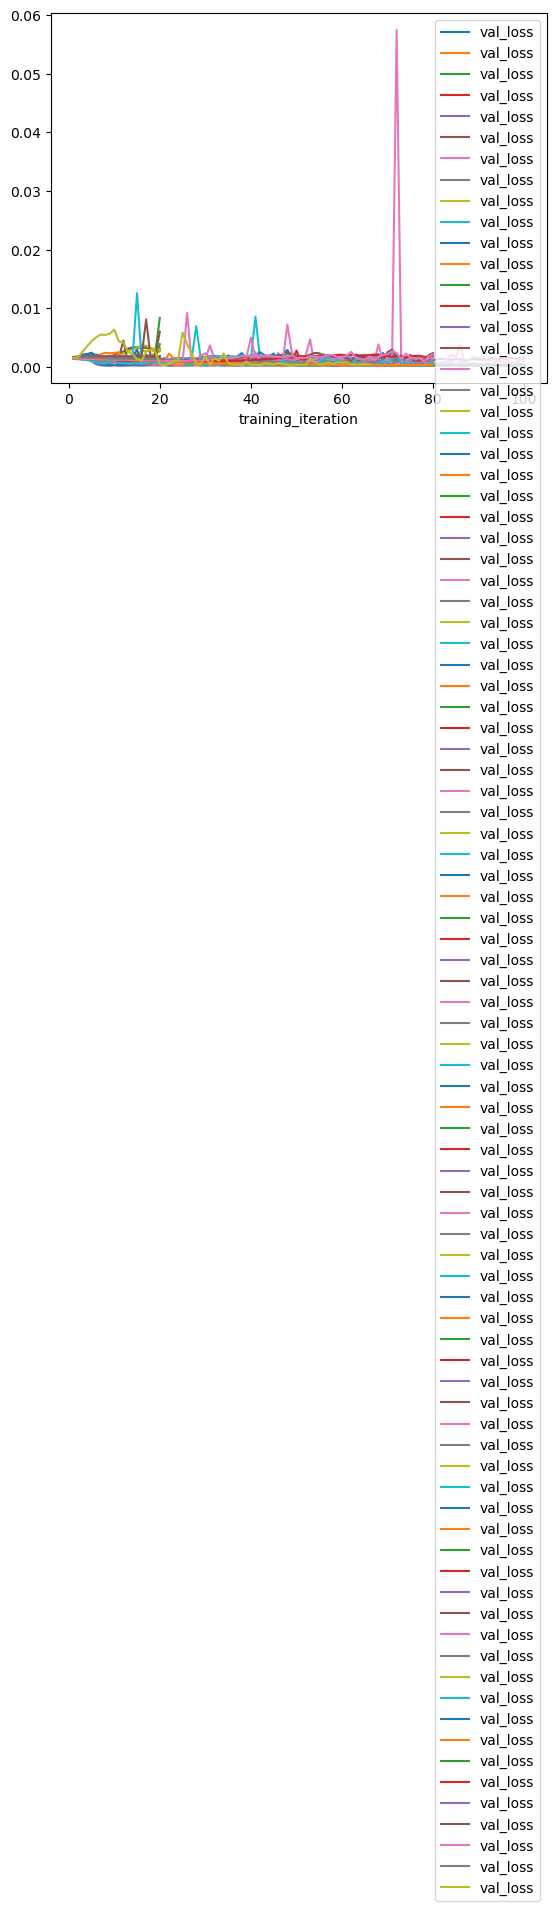

In [ ]:
ax = None
for result in results:
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "val_loss")
    else:
        result.metrics_dataframe.plot("training_iteration", "val_loss", ax=ax)
ax.set_title("ValLoss over epochs")
ax.set_ylabel('ValLoss')
ax.set_xlabel('Epochs')

In [ ]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print(f"The best model achieved a loss of {best_result.metrics['val_loss']}")
print(f"with the parameters growth_rate: {best_result.config['growth_rate']} init_features: {best_result.config['init_features']} bn_size: {best_result.config['bn_size']} drop_rate: {round(best_result.config['drop_rate'], 3)} learning_rate: {best_result.config['lr']}")

The best model achieved a loss of 0.00017433088214602321
with the parameters growth_rate: 12 init_features: 22 bn_size: 7 drop_rate: 0.135 learning_rate: 2.4461138851914485e-05


Training the selected model on training and validation data.
Testing on completely unseen testingdata.

In [ ]:
train_val_dataset = SliceIntensityDataset(train_val_images, train_val_labels, normalize=True, crop=0.7)
train_val_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
torch.manual_seed(SEED)
model = DenseNet(growth_rate=best_result.config['growth_rate'], num_init_features = best_result.config['init_features'], bn_size = best_result.config['bn_size'], drop_rate=best_result.config['drop_rate'], num_classes=1)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_result.config['lr'], weight_decay=best_result.config['weight_decay'])
losses = train_and_eval(model, train_val_loader, test_loader, optimizer, criterion, EPOCHS, device)

In [ ]:
from utils.model_utils import get_model_performance_metrics
train_val_sorted = get_model_performance_metrics(model, train_val_images, train_val_labels, device, True, 0.7)
test_sorted = get_model_performance_metrics(model, test_images, test_labels, device, True, 0.7)

In [ ]:
print("Performance on training data:")
print(f"TP: {len(train_val_sorted[0])} FP: {len(train_val_sorted[1])} TN: {len(train_val_sorted[2])} FN: {len(train_val_sorted[3])}\n")
print("Performance on validation data:")
print(f"TP: {len(test_sorted[0])} FP: {len(test_sorted[1])} TN: {len(test_sorted[2])} FN: {len(test_sorted[3])}\n")

In [ ]:
import matplotlib.pyplot as plt
# Fonts similar to latex document
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[0][:,0], label='Training loss')
plt.plot(losses[0][:,1], label='Validation loss')
plt.xlabel('Epoch')
plt.minorticks_on()
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(loc='upper right')

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[1][:,0], label='Validation accuracy')
plt.plot(losses[1][:,1], label='Validation precision')
plt.plot(losses[1][:,2], label='Validation recall')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.minorticks_on()
plt.title('Accuracy, Precision, Recall')
plt.legend(loc='lower right')